## Team Patrick AFK
- Gabriela Putri Jelita Sihutomo 0706012210048 
- Patrick Steven Kent Sugiarto 0706012210046 
- Dave Nathaniel Yoseph 0706012110042 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.metrics import confusion_matrix

## Load the Dataset

In [2]:
# Load dataset
url = 'water_potability.csv'
try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'water_potability.csv' was not found.")
    raise

Dataset loaded successfully.


## Data Exploration

In [3]:
print("\nDataset info:")
print(df.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None


In [4]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


## Data Visualization

[]

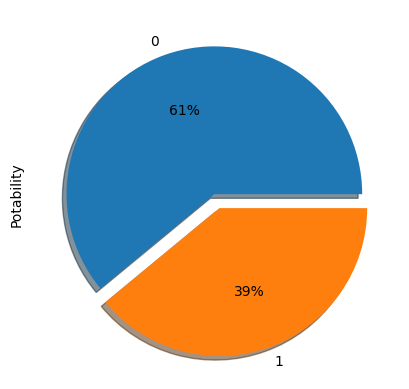

In [5]:
df['Potability'].value_counts().plot.pie(explode=(0,0.1),autopct="%.0f%%",shadow=True)
plt.plot()

Data distribution

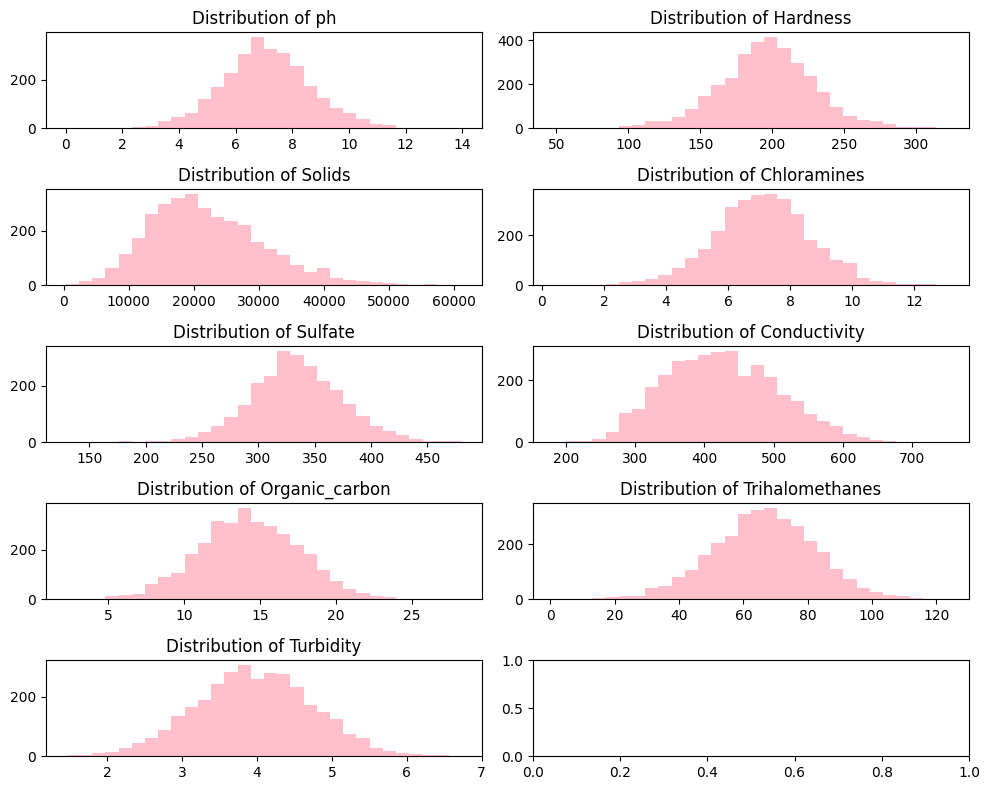

In [6]:
float_cols = df.select_dtypes('float64').columns
fig, axes = plt.subplots(len(float_cols)//2 + len(float_cols)%2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, col in enumerate(float_cols):
    axes[idx].hist(df[col], bins=30, color='pink')
    axes[idx].set_title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

Check for Outliers

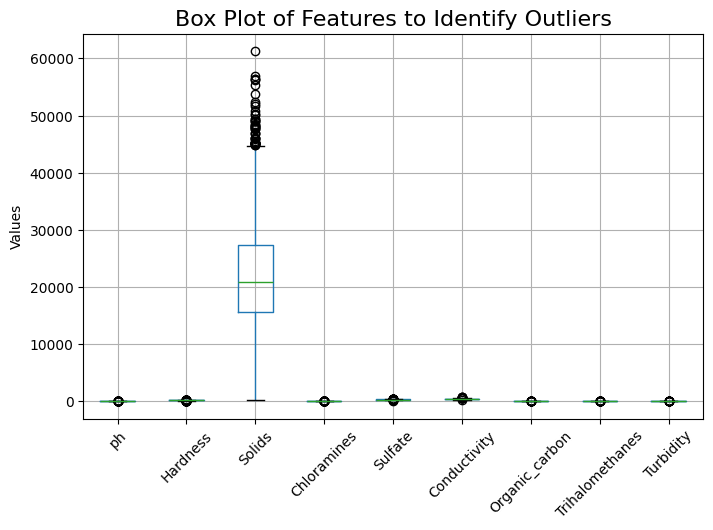

In [7]:
# create a box plot of total dissolved solids (solids) to identify outliers
plt.figure(figsize=(8, 5))
df.drop('Potability', axis=1).boxplot()
plt.title('Box Plot of Features to Identify Outliers', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Values')
plt.show()

## Data Preprocessing

1. Check and Handle Missing Values

In [8]:
df.columns = df.columns.str.strip()

print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))


Missing values:
Sulfate            781
ph                 491
Trihalomethanes    162
Hardness             0
Solids               0
Chloramines          0
Conductivity         0
Organic_carbon       0
Turbidity            0
Potability           0
dtype: int64


In [9]:
# Filling null values in Sulfate column with mode 
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].mode()[0])  
# Filling null values in ph column with it's mean 
df['ph'] = df['ph'].fillna(df['ph'].mean())                 
# Filling null values in Trihalomethanes column with mode
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].mode()[0])

In [10]:
# Displaying values after filling
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [11]:
print("\Data distribution in 'Potability':")
print(df['Potability'].value_counts())

\Data distribution in 'Potability':
0    1998
1    1278
Name: Potability, dtype: int64


In [12]:
features = df.drop('Potability', axis=1)
target = df['Potability']

2. Balancing data imbalance using SMOTE


Class distribution after SMOTE:
0    1998
1    1998
Name: Potability, dtype: int64


[]

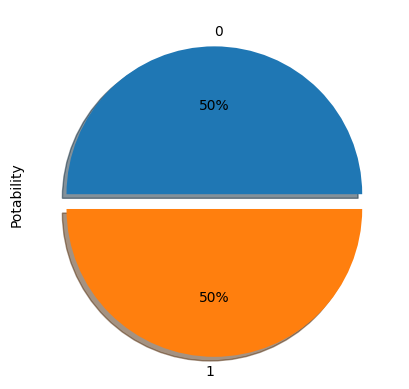

In [13]:
smote = SMOTE(random_state=42)
features_resampled, target_resampled = smote.fit_resample(features, target)
print("\nClass distribution after SMOTE:")
print(pd.Series(target_resampled).value_counts())
target_resampled.value_counts().plot.pie(explode=(0,0.1),autopct="%.0f%%",shadow=True)
plt.plot()


3. Data splitting

In [14]:
x_train, x_test, y_train, y_test = train_test_split(features_resampled, target_resampled, test_size=0.2, random_state=42, stratify=target_resampled)

4. Data scaling using RobustScaler

In [15]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Model Creation

1. Initialize models

In [16]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

2. Tuning the hyperparameters

In [17]:
param_grids = {
    "Random Forest": {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],  # Reduced from [None, 10, 20]
    'min_samples_split': [5, 10],  # Increased minimum from 2
    'min_samples_leaf': [4, 8],  # Added to prevent overfitting
    'max_features': ['sqrt', 'log2']  #
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
    },
    "Logistic Regression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    }
}

results_list = []

3. Train and evaluate each model with classification report and confusion matrix


Model: Random Forest
Fitting 3 folds for each of 48 candidates, totalling 144 fits


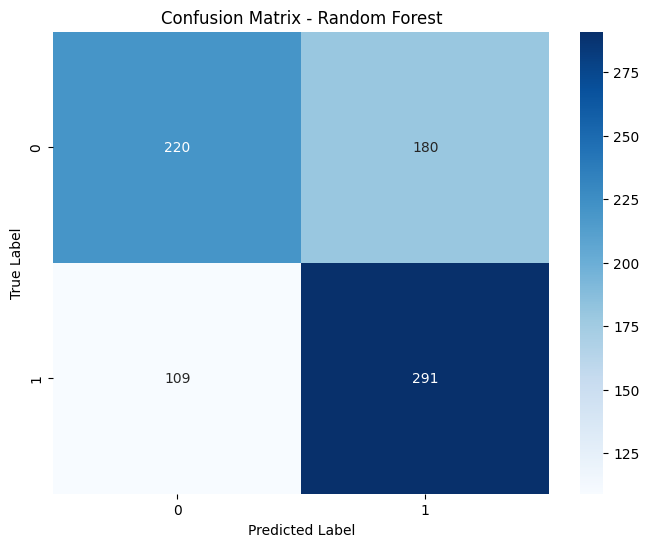

Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV Score: 0.6292

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.55      0.60       400
           1       0.62      0.73      0.67       400

    accuracy                           0.64       800
   macro avg       0.64      0.64      0.64       800
weighted avg       0.64      0.64      0.64       800


Confusion Matrix:
[[220 180]
 [109 291]]

Model: XGBoost
Fitting 3 folds for each of 27 candidates, totalling 81 fits


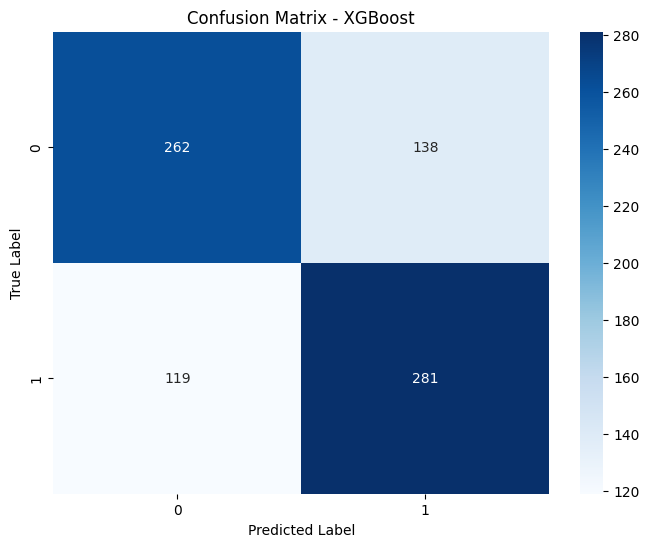

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best CV Score: 0.6639

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       400
           1       0.67      0.70      0.69       400

    accuracy                           0.68       800
   macro avg       0.68      0.68      0.68       800
weighted avg       0.68      0.68      0.68       800


Confusion Matrix:
[[262 138]
 [119 281]]

Model: SVM
Fitting 3 folds for each of 6 candidates, totalling 18 fits


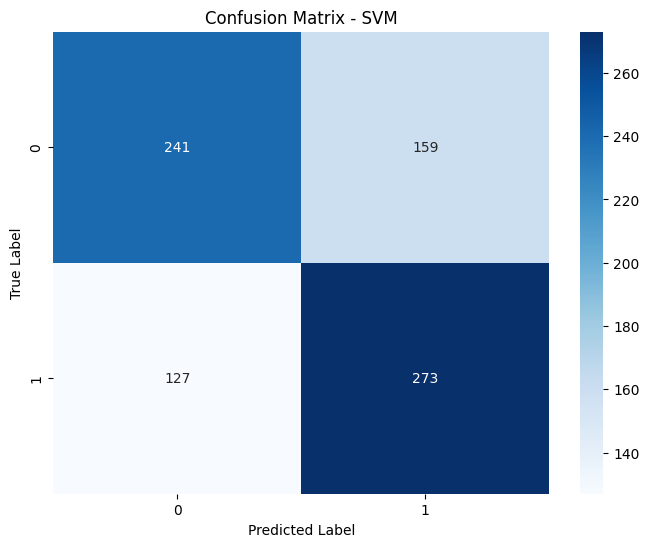

Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best CV Score: 0.6640

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.60      0.63       400
           1       0.63      0.68      0.66       400

    accuracy                           0.64       800
   macro avg       0.64      0.64      0.64       800
weighted avg       0.64      0.64      0.64       800


Confusion Matrix:
[[241 159]
 [127 273]]

Model: Logistic Regression
Fitting 3 folds for each of 48 candidates, totalling 144 fits


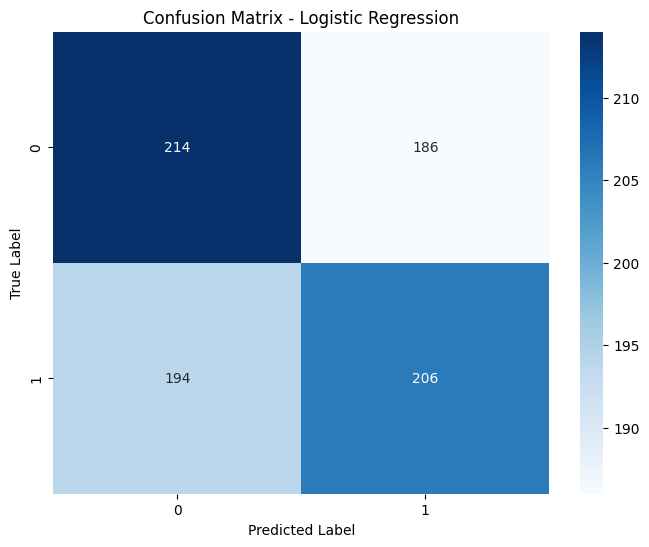

Best Parameters: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.5150

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       400
           1       0.53      0.52      0.52       400

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.52       800
weighted avg       0.53      0.53      0.52       800


Confusion Matrix:
[[214 186]
 [194 206]]


In [18]:
model_metrics = {}


for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print('='*50)
    
    try:
        # GridSearch
        grid_search = GridSearchCV(
            model, 
            param_grids[name], 
            cv=3, 
            scoring='accuracy', 
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(x_train_scaled, y_train)
        
        # Best model
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(x_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Store metrics
        model_metrics[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'model': best_model,
            'parameters': grid_search.best_params_,
            'cv_score': grid_search.best_score_,
            'confusion_matrix': cm
        }
        
        # Print results
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best CV Score: {grid_search.best_score_:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("\nConfusion Matrix:")
        print(cm)
        
    except Exception as e:
        print(f"Error occurred while tuning {name}: {e}")

In [19]:
import pickle

# Save the best model
model_filename = 'best_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved to {model_filename}.")

Model saved to best_model.pkl.


In [20]:
# Assuming 'features_resampled' contains your training features
scaler = RobustScaler()
scaler.fit(features_resampled)  # Fit on your training data

# Save the scaler
scaler_filename = 'robust_scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

print(f"Scaler saved to {scaler_filename}.")

Scaler saved to robust_scaler.pkl.
